# scplotter to work with seqFISH data prepared by Giotto

See: <https://drieslab.github.io/Giotto_website/articles/mini_seqfish.html>

Go back to scplotter documentation: <https://pwwang.github.io/scplotter/>

In [1]:
library(Giotto)

# Ensure Giotto can access a python env
genv_exists <- suppressMessages(checkGiottoEnvironment())
print(genv_exists)

python_path <- file.path(Sys.getenv("HOME"), "miniconda3", "envs", "giotto_env", "bin", "python")
Sys.setenv(RETICULATE_PYTHON = python_path)

invisible(capture.output(suppressMessages(set_giotto_python_path(python_path = python_path))))

# library(scplotter)
devtools::load_all()

Loading required package: GiottoClass



Newer devel version of GiottoClass on GitHub: 0.4.8

Giotto Suite 4.2.1



[1] TRUE


ℹ Loading scplotter


In [2]:
seqfish_mini <- GiottoData::loadGiottoMini("seqfish")
seqfish_mini

1. read Giotto object

2. read Giotto feature information

3. read Giotto spatial information

4. read Giotto image information



python already initialized in this session
 active environment : 'giotto_env'
 python version : 3.10



An object of class giotto 
>Active spat_unit:  cell 
>Active feat_type:  rna 
dimensions    : 1774, 118 (features, cells)
[SUBCELLULAR INFO]
[AGGREGATE INFO]
expression -----------------------
  [cell][rna] raw
spatial locations ----------------
  [cell] raw


Use objHistory() to see steps and params used

In [3]:
seqfish_mini <- filterGiotto(gobject = seqfish_mini,
                             expression_threshold = 0.5,
                             feat_det_in_min_cells = 20,
                             min_det_feats_per_cell = 0)

seqfish_mini <- normalizeGiotto(gobject = seqfish_mini,
                                scalefactor = 6000,
                                verbose = TRUE)

seqfish_mini <- addStatistics(gobject = seqfish_mini)

seqfish_mini <- adjustGiottoMatrix(gobject = seqfish_mini,
                                   expression_values = "normalized",
                                   covariate_columns = c("nr_feats", "total_expr"))
seqfish_mini <- calculateHVF(gobject = seqfish_mini)
seqfish_mini <- runPCA(gobject = seqfish_mini)
seqfish_mini <- runUMAP(seqfish_mini,
                        dimensions_to_use = 1:5,
                        n_threads = 2)
seqfish_mini <- runtSNE(seqfish_mini,
                        dimensions_to_use = 1:5)
seqfish_mini <- createNearestNetwork(gobject = seqfish_mini,
                                     dimensions_to_use = 1:5,
                                     k = 5)

seqfish_mini <- doLeidenCluster(gobject = seqfish_mini,
                                resolution = 0.4,
                                n_iterations = 1000)
clusters_cell_types <- c("cell A", "cell B", "cell C", "cell D",
                        "cell E", "cell F", "cell G", "cell H")

names(clusters_cell_types) <- 1:8

seqfish_mini <- annotateGiotto(gobject = seqfish_mini,
                               annotation_vector = clusters_cell_types,
                               cluster_column = "leiden_clus",
                               name = "cell_types")
seqfish_mini <- createSpatialNetwork(gobject = seqfish_mini,
                                     minimum_k = 2,
                                     maximum_distance_delaunay = 400)

seqfish_mini <- createSpatialNetwork(gobject = seqfish_mini,
                                     minimum_k = 2,
                                     method = "kNN",
                                     k = 10)
km_spatialfeats <- binSpect(seqfish_mini)

completed 1: preparation

completed 2: subset expression data

completed 3: subset spatial locations

completed 4: subset cell metadata

completed 5: subset feature metadata

completed 6: subset spatial network(s)

completed 7: subsetted dimension reductions

completed 8: subsetted nearest network(s)

completed 9: subsetted spatial enrichment results




Feature type:  rna 
Number of cells removed:  0  out of  118 
Number of feats removed:  435  out of  1774 


first scale feats and then cells

Setting expression [cell][rna] normalized

Setting expression [cell][rna] scaled



calculating statistics for "normalized" expression

Setting expression [cell][rna] custom

"hvf" column was found in the feats metadata information and will be
 used to select highly variable features

Warning message in .run_pca_biocsingular(x = t_flex(expr_values), center = center, :
“ncp >= minimum dimension of x, will be set to
                minimum dimension of x - 1”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invalid!; try increasing work or maxit”
Setting dimension reduction [cell][rna] pca

Setting dimension reduction [cell][rna] umap

Setting dimension reduction [cell][rna] tsne

Setting spatial network [cell] Delaunay_network

Setting spatial network [cell] kNN_network


This is the single paramete

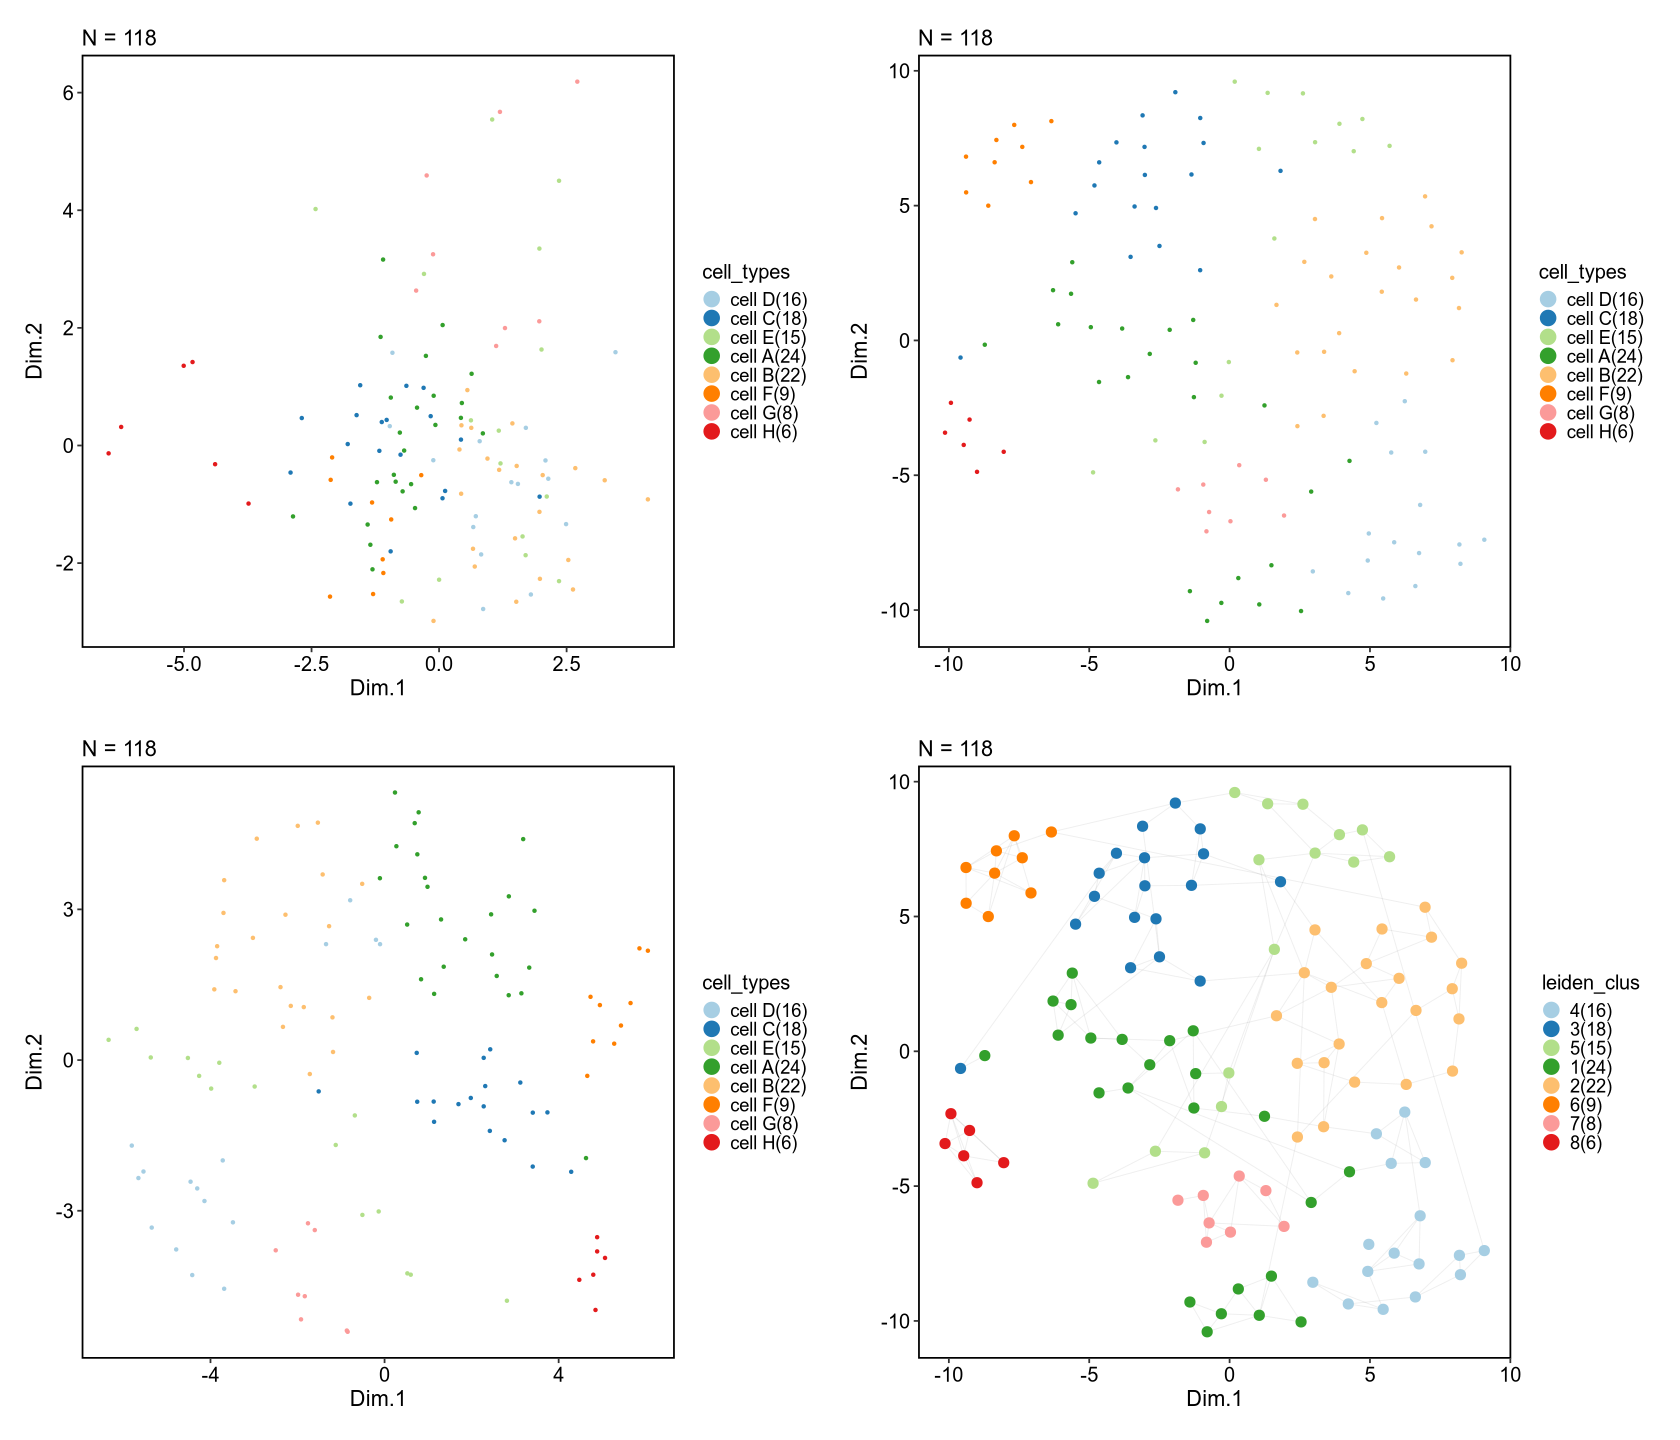

In [8]:
options(repr.plot.width = 14, repr.plot.height = 12)

p1 <- CellDimPlot(seqfish_mini, group_by = "cell_types")
p2 <- CellDimPlot(seqfish_mini, group_by = "cell_types", reduction = "umap")
p3 <- CellDimPlot(seqfish_mini, group_by = "cell_types", reduction = "tsne")
p4 <- CellDimPlot(seqfish_mini, group_by = "leiden_clus", reduction = "umap",
    graph = TRUE, pt_size = 2.5)

(p1 + p2) / (p3 + p4)

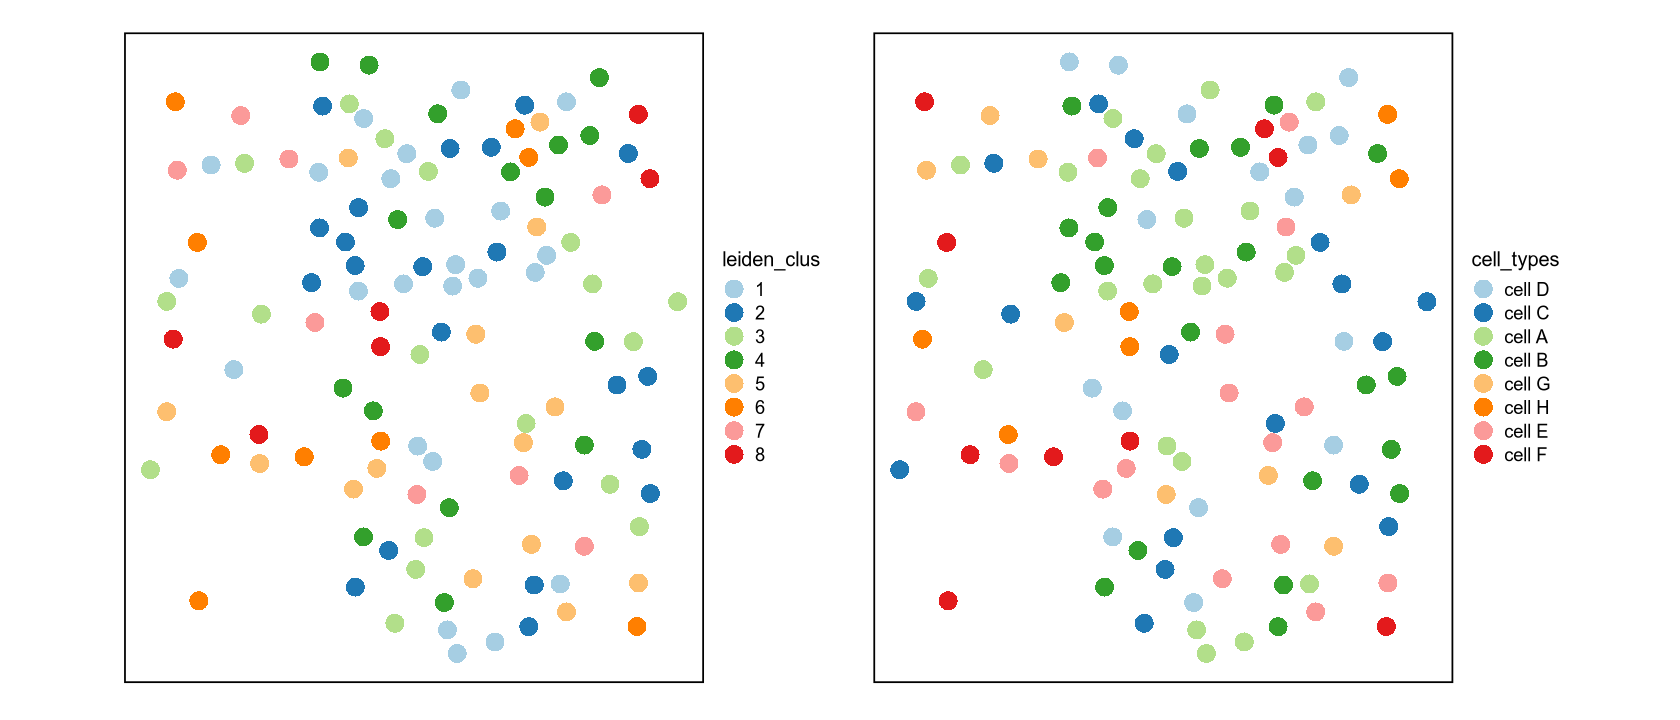

In [15]:
options(repr.plot.width = 14, repr.plot.height = 6)

seqfish_mini@cell_metadata$cell$rna$leiden_clus <- factor(
    seqfish_mini@cell_metadata$cell$rna$leiden_clus
)

p1 <- SpatDimPlot(seqfish_mini,
            size = 5,
            group_by = "leiden_clus")
p2 <- SpatDimPlot(seqfish_mini,
            size = 5,
            group_by = "cell_types")

p1 + p2

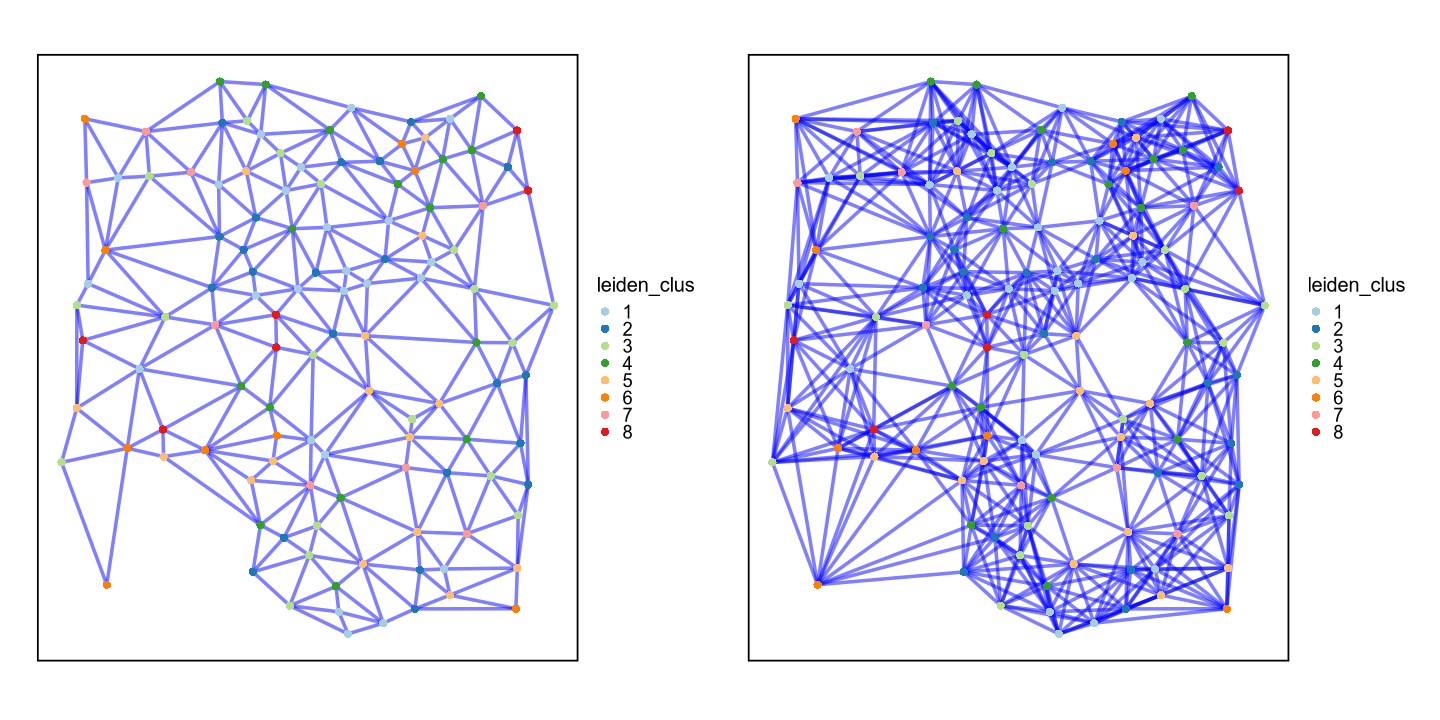

In [27]:
options(repr.plot.width = 12, repr.plot.height = 6)

p1 <- SpatDimPlot(seqfish_mini,
    size = 2,
    graph = "Delaunay_network",
    edge_color = "blue",
    edge_size = 1,
    edge_alpha = 0.5,
    group_by = "leiden_clus")
p2 <- SpatDimPlot(seqfish_mini,
    size = 2,
    graph = "kNN_network",
    edge_color = "blue",
    edge_size = 1,
    edge_alpha = 0.5,
    group_by = "leiden_clus")
p1 + p2

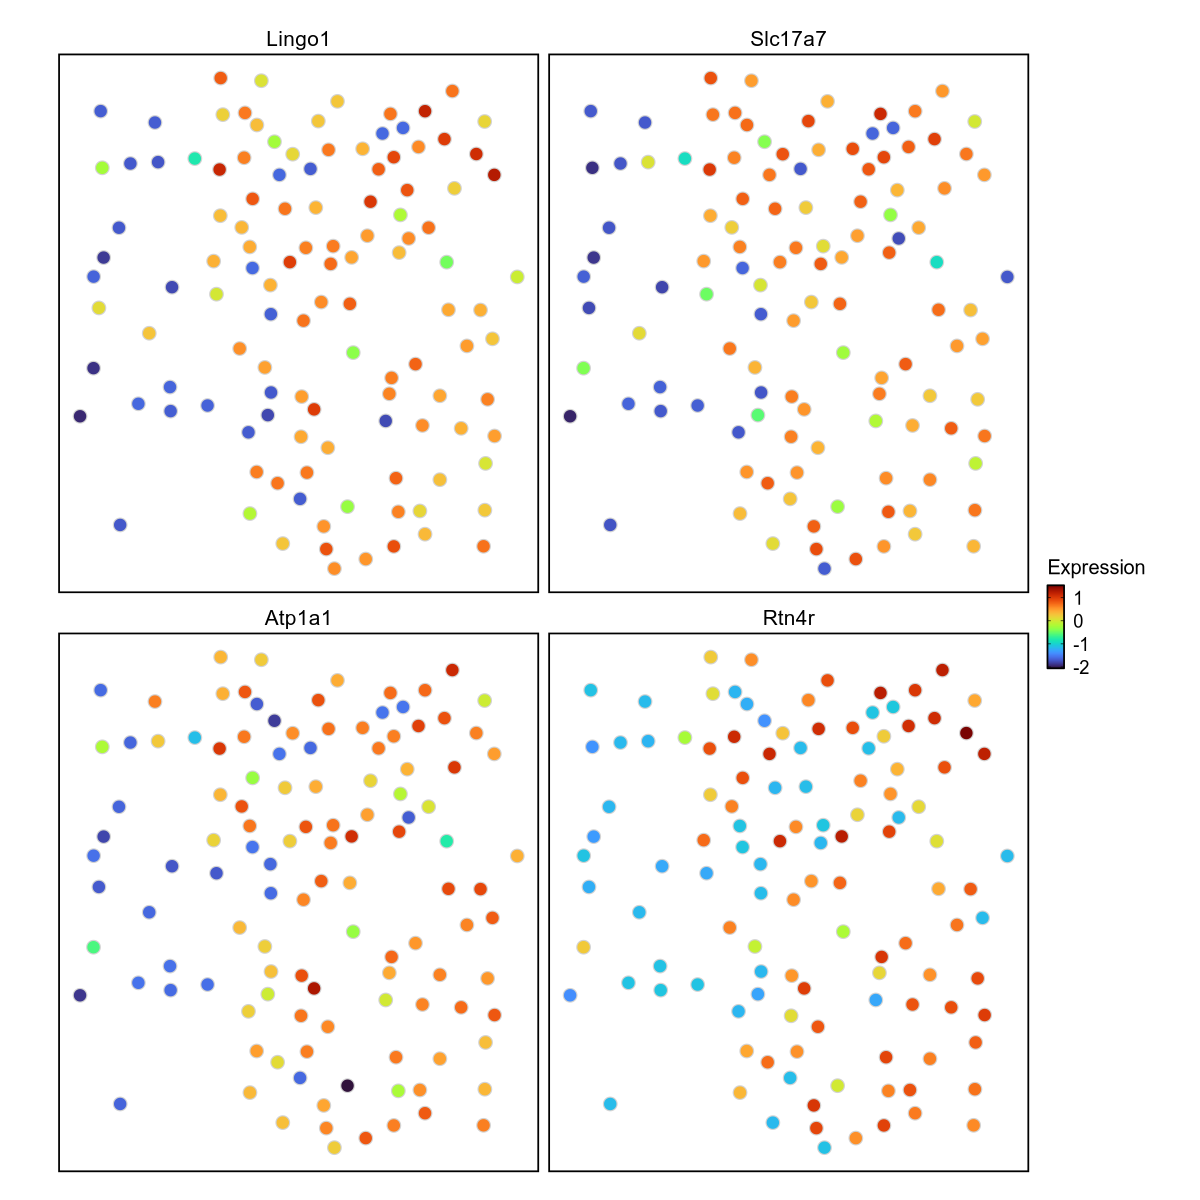

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)

SpatFeaturePlot(
    seqfish_mini,
    layer = "scaled",
    shape = 21,
    size = 3.5,
    border_color = "lightgrey",
    features = km_spatialfeats[1:4]$feats
)

In [4]:
x <- sessionInfo()
x <- capture.output(print(x))
# hide the BLAS/LAPACK paths
x <- x[!startsWith(x, "BLAS/LAPACK:")]
cat(paste(x, collapse = "\n"))

R version 4.4.3 (2025-02-28)
Platform: x86_64-conda-linux-gnu
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=C              
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Chicago
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scplotter_0.4.0   Giotto_4.2.1      GiottoClass_0.4.7

loaded via a namespace (and not attached):
  [1] fs_1.6.6                    matrixStats_1.5.0          
  [3] spatstat.sparse_3.1-0       bitops_1.0-9               
  [5] devtools_2.4.5              httr_1.4.7                 
  [7] RColorBrewer_1.1-3 